# Project: Protein stability prediction

In the project you will try to predict protein stability changes upon point mutations. 
We will use acuumulated data from experimental databases, i.e. the Megascale dataset. A current [paper](https://www.pnas.org/doi/10.1073/pnas.2314853121) has already preprocessed the dataset and created homology reduced data splits. We will reuse these.

The downloaded data includes measurements of changes in the Gibbs free enrgy ($\Delta \Delta G $). 
This will be the value that you will have to predict for a given protein with a point mutation. 

Here we will use protein embeddings computed by ESM as input. 
We provide precomputed embeddings from the last layer of the smallest ESM model. You can adjust the Dataloader's code to load the embedding of the wild type or of the mutated sequence or both. You can use it however you like. This is just to provide you easy access to embeddings. If you want to compute your own embeddings from other layers or models you can do that, too. 

Below we provide you with a strcuture for the project that you can start with.  
Edit the cells to your liking and add more code to create your final model.


## Imports

In [1]:
%pip install tensorboard

  Using cached tensorboard_data_server-0.7.2-py3-none-any.whl.metadata (1.1 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 8.4 MB/s eta 0:00:00a 0:00:01
Using cached tensorboard_data_server-0.7.2-py3-none-any.whl (2.4 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 11.7 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7/7 [tensorboard] [tensorboard]

[notice] A new release of pip is available: 25.1.1 -> 26.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
import os 
import numpy as np
import pandas as pd
import scipy
import sklearn.metrics as skmetrics

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import lightning as L

import torchmetrics
from torchmetrics.regression import PearsonCorrCoef

## Dataloading

We are using the Megascale dataset. The train, validation and test sets are already predefined.  
As mentioned, we provide embeddings from the last layer of ESM as input. You can access either the wild type or the mutated sequence and you could also further adjsut the embeddings. 
Here we have an embedding representing the complete sequence. It was computed by averaging over the embeddings per residue in the sequence. 

The ``Dataset`` classes return tuples of ``(embedding, ddg_value)``.

In [2]:
class ProtEmbeddingDataset(Dataset):
    """
    Dataset that returns (mut_embedding, wt_embedding, ddG_label).
    WT embedding is required; raises an error if missing.
    """
    def __init__(self, tensor_folder, csv_file, id_col="name", label_col="ddG_ML", layer=6):
        self.tensor_folder = tensor_folder
        self.layer = layer

        self.df = pd.read_csv(csv_file, sep=",")
        self.df = self.df[self.df.mut_type != "wt"].reset_index(drop=True)

        self.labels = torch.tensor(self.df[label_col].values, dtype=torch.float32)
        self.ids = self.df[id_col].values
        self.wt_names = self.df["WT_name"].values

    def __len__(self):
        return len(self.labels)

    def _load_emb(self, name: str, suffix: str | None = None):
        fname = f"{name}{suffix if suffix else ''}.pt"
        path = os.path.join(self.tensor_folder, fname)
        obj = torch.load(path, map_location="cpu")
        return obj["mean_representations"][self.layer].float()

    def __getitem__(self, idx):
        # mutant embedding (must exist)
        emb_mut = self._load_emb(self.ids[idx], suffix=None)

        # wildtype embedding: must exist with one of the suffixes
        wt_base = self.wt_names[idx]
        wt_path1 = os.path.join(self.tensor_folder, wt_base + "_wte.pt")
        wt_path2 = os.path.join(self.tensor_folder, wt_base + "_wty.pt")

        if os.path.exists(wt_path1):
            emb_wt = self._load_emb(wt_base, suffix="_wte")
        elif os.path.exists(wt_path2):
            emb_wt = self._load_emb(wt_base, suffix="_wty")
        else:
            raise FileNotFoundError(
                f"WT embedding missing for WT_name='{wt_base}' "
                f"(tried '{wt_base}_wte.pt' and '{wt_base}_wty.pt')"
            )

        label = self.labels[idx]
        return emb_mut, emb_wt, label

In [3]:
# usage 
# make sure to adjust the paths to where your files are located
dataset_train = ProtEmbeddingDataset('project_data/mega_train_embeddings', 'project_data/mega_train.csv')
dataset_val = ProtEmbeddingDataset('project_data/mega_val_embeddings', 'project_data/mega_val.csv')
# dataset_test = ProtEmbeddingDataset('project_data/mega_test_embeddings', 'project_data/mega_test.csv') # only once available

dataloader_train = DataLoader(dataset_train, batch_size=1024, shuffle=True, num_workers=16)
dataloader_val = DataLoader(dataset_val, batch_size=512, shuffle=False, num_workers=16)
# dataloader_test = DataLoader(dataset_test, batch_size=32, shuffle=False)

/Users/jianzhouyao/Library/Mobile Documents/com~apple~CloudDocs/Universität/ETH/DL in Biology/Dry_Lab/bc_deep_learning_in_biology/venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:424: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 10 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  self.check_worker_number_rationality()


## Model architecture and training

Now it's your turn. Create a model trained on the embeddings and the corresponding ddG values.  
Be aware that this is not a classification task, but a regression task. You want to predict a continuous number that is as close to the measured $\Delta \Delta G $ value as possible.
You will need to adjust your architecture and loss accordingly.

Train the model with the predefined dataloaders. And try to improve the model. 
Only test on the test set at the very end, when you have finished fine-tuning you model. 

Using compute device: mps
Training started. Logs saving to: runs/Siamese_Protein_Run_Regularized


Epoch 1/5:   0%|          | 0/211 [00:00<?, ?it/s]

Epoch 01 | Train MSE: 0.9634 | Val RMSE: 0.7966 | Pearson: 0.5109
  ✅ New best model saved at epoch 1


Epoch 2/5:   0%|          | 0/211 [00:00<?, ?it/s]

Epoch 02 | Train MSE: 0.7490 | Val RMSE: 0.8019 | Pearson: 0.5043
  ⏸ No improvement. Early stop counter: 1/2


Epoch 3/5:   0%|          | 0/211 [00:00<?, ?it/s]

Epoch 03 | Train MSE: 0.6892 | Val RMSE: 0.8083 | Pearson: 0.5043
  ⏸ No improvement. Early stop counter: 2/2
  🛑 Early stopping triggered.
Loading best model from epoch 1
===== Final Validation Metrics (Best Checkpoint) =====
RMSE     : 0.7966
Pearson  : 0.5109
Spearman : 0.4551


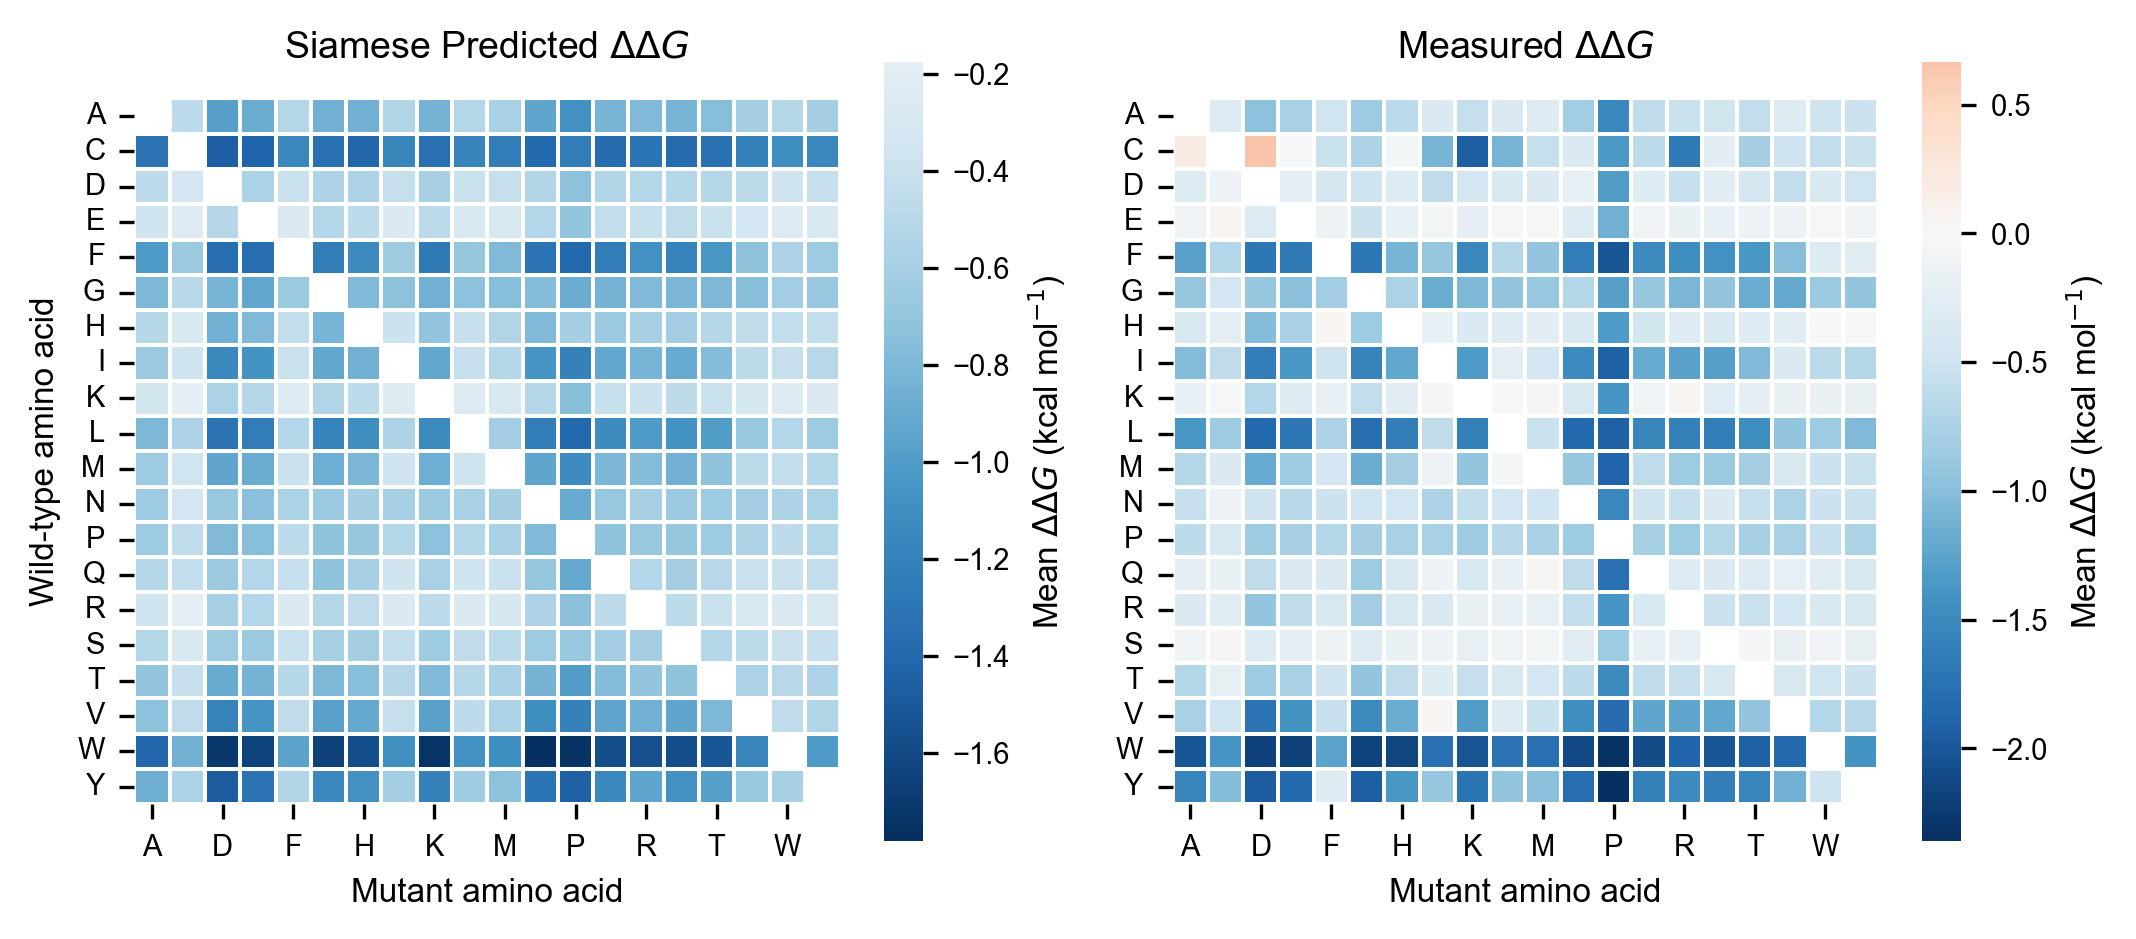

In [4]:
# %% [markdown]
# ## Global Styling & TensorBoard Setup

# %%
import os
import math
import numpy as np
import pandas as pd
import scipy.stats
import sklearn.metrics as skmetrics
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

from torch.utils.tensorboard import SummaryWriter

# ── Global "Nature Style" Formatting ──────────────────────────────────────────
nature_style = {
    "font.family": "sans-serif",
    "font.sans-serif": ["Arial", "Helvetica", "DejaVu Sans"],
    "font.size": 8, "axes.labelsize": 8, "axes.titlesize": 9,
    "xtick.labelsize": 7, "ytick.labelsize": 7, "legend.fontsize": 7,
    "axes.linewidth": 0.8, "lines.linewidth": 1.5,
    "figure.dpi": 300, "savefig.bbox": "tight",
    "axes.spines.top": False, "axes.spines.right": False,
    "legend.frameon": False
}
mpl.rcParams.update(nature_style)

# Device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using compute device: {device}")

# %% [markdown]
# ## 1. Siamese Relational Network Architecture (with stronger dropout)

# %%
class SiameseProteinNet(nn.Module):
    def __init__(self, input_dim=768, latent_dim=256):
        super().__init__()
        # Encoder (Shared weights)
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.GELU(),
            nn.Dropout(0.5),              # ↑ stronger dropout
            nn.Linear(512, latent_dim),
            nn.BatchNorm1d(latent_dim),
            nn.GELU(),
            nn.Dropout(0.5),              # ↑ extra dropout
        )
        # Relational Head
        self.regressor = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(latent_dim * 4, 128),
            nn.BatchNorm1d(128),
            nn.GELU(),
            nn.Dropout(0.5),
            nn.Linear(128, 1)
        )

    def forward(self, mut_emb, wt_emb):
        z_mut = self.encoder(mut_emb)
        z_wt  = self.encoder(wt_emb)

        z_diff = z_mut - z_wt
        z_prod = z_mut * z_wt

        combined = torch.cat([z_mut, z_wt, z_diff, z_prod], dim=-1)
        return self.regressor(combined).squeeze(-1)

model_siamese = SiameseProteinNet().to(device)

# %% [markdown]
# ## 2. Training with Early Stopping + Best Checkpoint

# %%
# Dataloaders
dataloader_train = DataLoader(dataset_train, batch_size=1024, shuffle=True, num_workers=0)
dataloader_val   = DataLoader(dataset_val, batch_size=512, shuffle=False, num_workers=0)

# Hyperparameters
epochs = 5
patience = 2

criterion = nn.MSELoss()
optimizer = optim.AdamW(
    model_siamese.parameters(),
    lr=1e-3,
    weight_decay=1e-3        # ↑ stronger weight decay
)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=1)

# TensorBoard
log_dir = "runs/Siamese_Protein_Run_Regularized"
writer = SummaryWriter(log_dir)

sample_mut, sample_wt, _ = next(iter(dataloader_train))
writer.add_graph(model_siamese, (sample_mut.to(device), sample_wt.to(device)))

print(f"Training started. Logs saving to: {log_dir}")

# Early stopping & checkpointing
best_val_loss = float("inf")
best_epoch = -1
early_stop_counter = 0
ckpt_path = "best_siamese_model.pt"

for epoch in range(epochs):
    # --- TRAINING ---
    model_siamese.train()
    running_loss = 0.0

    for emb_mut, emb_wt, labels in tqdm(dataloader_train, desc=f"Epoch {epoch+1}/{epochs}"):
        emb_mut, emb_wt, labels = emb_mut.to(device), emb_wt.to(device), labels.to(device)

        optimizer.zero_grad()
        predictions = model_siamese(emb_mut, emb_wt)
        loss = criterion(predictions, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * labels.size(0)

    epoch_train_loss = running_loss / len(dataset_train)

    # --- VALIDATION ---
    model_siamese.eval()
    running_val_loss = 0.0
    val_preds, val_labels_list = [], []

    with torch.no_grad():
        for emb_mut, emb_wt, labels in dataloader_val:
            emb_mut, emb_wt, labels = emb_mut.to(device), emb_wt.to(device), labels.to(device)

            predictions = model_siamese(emb_mut, emb_wt)
            loss = criterion(predictions, labels)

            running_val_loss += loss.item() * labels.size(0)
            val_preds.extend(predictions.cpu().numpy())
            val_labels_list.extend(labels.cpu().numpy())

    epoch_val_loss = running_val_loss / len(dataset_val)
    scheduler.step(epoch_val_loss)

    current_rmse = math.sqrt(epoch_val_loss)
    current_pearson, _ = scipy.stats.pearsonr(val_preds, val_labels_list)
    current_lr = optimizer.param_groups[0]["lr"]

    # TensorBoard logging
    writer.add_scalar("Loss/Train", epoch_train_loss, epoch)
    writer.add_scalar("Loss/Validation", epoch_val_loss, epoch)
    writer.add_scalar("Metrics/Validation_RMSE", current_rmse, epoch)
    writer.add_scalar("Metrics/Validation_Pearson", current_pearson, epoch)
    writer.add_scalar("Hyperparameters/Learning_Rate", current_lr, epoch)

    print(f"Epoch {epoch+1:02d} | Train MSE: {epoch_train_loss:.4f} | Val RMSE: {current_rmse:.4f} | Pearson: {current_pearson:.4f}")

    # --- CHECKPOINT + EARLY STOPPING ---
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        best_epoch = epoch
        early_stop_counter = 0
        torch.save(model_siamese.state_dict(), ckpt_path)
        print(f"  ✅ New best model saved at epoch {epoch+1}")
    else:
        early_stop_counter += 1
        print(f"  ⏸ No improvement. Early stop counter: {early_stop_counter}/{patience}")

        if early_stop_counter >= patience:
            print("  🛑 Early stopping triggered.")
            break

writer.close()
if torch.backends.mps.is_available():
    torch.mps.empty_cache()

# %% [markdown]
# ## 3. Reload Best Model and Recompute Validation Predictions

# %%
print(f"Loading best model from epoch {best_epoch+1}")
model_siamese.load_state_dict(torch.load(ckpt_path, map_location=device))
model_siamese.eval()

val_preds, val_labels_list = [], []

with torch.no_grad():
    for emb_mut, emb_wt, labels in dataloader_val:
        emb_mut, emb_wt = emb_mut.to(device), emb_wt.to(device)
        predictions = model_siamese(emb_mut, emb_wt)
        val_preds.extend(predictions.cpu().numpy())
        val_labels_list.extend(labels.numpy())

val_preds_arr = np.array(val_preds)
val_labels_arr = np.array(val_labels_list)

final_rmse = np.sqrt(skmetrics.mean_squared_error(val_labels_arr, val_preds_arr))
final_pearson, _ = scipy.stats.pearsonr(val_preds_arr, val_labels_arr)
final_spearman, _ = scipy.stats.spearmanr(val_preds_arr, val_labels_arr)

print("===== Final Validation Metrics (Best Checkpoint) =====")
print(f"RMSE     : {final_rmse:.4f}")
print(f"Pearson  : {final_pearson:.4f}")
print(f"Spearman : {final_spearman:.4f}")
print("=====================================================")

# %% [markdown]
# ## 4. Final Evaluation & Publication-Ready Heatmap

# %%
df_val_mut = pd.read_csv("project_data/mega_val.csv")
df_val_mut = df_val_mut[df_val_mut.mut_type != "wt"].copy()
df_val_mut["wt_aa"]  = df_val_mut["mut_type"].str[0]
df_val_mut["mut_aa"] = df_val_mut["mut_type"].str[-1]

df_val_mut["pred_ddG"] = val_preds_arr

pivot_pred = df_val_mut.groupby(["wt_aa", "mut_aa"])["pred_ddG"].mean().unstack()
pivot_true = df_val_mut.groupby(["wt_aa", "mut_aa"])["ddG_ML"].mean().unstack()

fig, axes = plt.subplots(1, 2, figsize=(7.2, 3.5))

heatmaps = [pivot_pred, pivot_true]
titles = [r"Siamese Predicted $\Delta\Delta G$", r"Measured $\Delta\Delta G$"]  # raw strings = no warning

for i, (ax, data, title) in enumerate(zip(axes, heatmaps, titles)):
    sns.heatmap(
        data, cmap="RdBu_r", center=0, ax=ax,
        square=True, linewidths=0.5, linecolor="white",
        cbar_kws={"label": r"Mean $\Delta\Delta G$ (kcal mol$^{-1}$)", "shrink": 0.8}
    )
    ax.set_title(title, pad=10)
    ax.set_xlabel("Mutant amino acid")
    ax.set_ylabel("Wild-type amino acid" if i == 0 else "")
    ax.tick_params(axis="x", rotation=0)
    ax.tick_params(axis="y", rotation=0)

plt.tight_layout()
plt.show()

1. The Shared Encoder (Weight Sharing)
In the SiameseProteinNet class, you define self.encoder once. In the forward pass, you call it twice:

Python
z_mut = self.encoder(mut_emb)
z_wt  = self.encoder(wt_emb)
This is the "Siamese" part. By using the exact same weights to process both the mutant and the wild-type embeddings, the model is forced to map both proteins into the same latent space. It ensures that the representation of a "Leucine" is consistent whether it’s in the WT or the Mutant.

2. Multi-Feature Interaction (The "Relational" Head)
Most basic Siamese networks just subtract the two vectors. Your code uses a much more sophisticated "Relational Head." You are creating a "Super-Vector" for the regressor:

Python
z_diff = z_mut - z_wt         # Captures the direction/magnitude of change
z_prod = z_mut * z_wt         # Captures element-wise similarity (Hadamard product)
combined = torch.cat([z_mut, z_wt, z_diff, z_prod], dim=-1) # Concatenation
By concatenating the raw features, the difference, and the product, you are giving the final regressor four different "perspectives" on how the mutation changed the protein:

Absolute state: What do the WT and Mutant look like individually?

Differential state: Exactly what changed?

Interaction state: Which features are reinforced or cancelled out?